In [7]:
import sys
print(sys.executable)
# should be c:\Users\parke\Documents\GitHub\CASTER\venv\Scripts\python.exe

import os
print(os.getcwd())
os.chdir('DDE')
print(os.getcwd())

c:\Users\parke\Documents\GitHub\CASTER\venv\Scripts\python.exe
c:\Users\parke\Documents\GitHub\CASTER\DDE


FileNotFoundError: [WinError 2] The system cannot find the file specified: 'DDE'

In [ ]:
path_to_sup_train_valid_smiles = '.\data\BIOSNAP\sup_train_val.csv'
df = pd.read_csv(path_to_sup_train_valid)
df.head()

NameError: name 'pd' is not defined

# the import work in the current venv

1. there is now a problem with only using cpus for the deep learning

In [10]:
import os
print(os.getcwd())
try:
    os.chdir('DDE')
except:
    print('you are already in DDE')
    print(os.getcwd())


import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch import nn 
import copy

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold
torch.manual_seed(2)    # reproducible torch:2 np:3
np.random.seed(3)

from dde_config import dde_NN_config
from dde_torch import dde_NN_Large_Predictor
from stream_dde import supData, unsupData

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.device('cpu') # hard coded this because I don't have any GPUs
device

c:\Users\parke\Documents\GitHub\CASTER\DDE
you are already in DDE
c:\Users\parke\Documents\GitHub\CASTER\DDE


device(type='cpu')

In [ ]:
torch.cuda.is_available()

False

In [18]:
def test_dde_nn(data_generator, model_nn):
    y_pred = []
    y_label = []
    model_nn.eval()
    for i, (v_D, label) in enumerate(data_generator):
        recon, code, score, Z_f, z_D = model_nn(v_D.float().cuda())
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score)).detach().cpu().numpy()
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()

    return roc_auc_score(y_label, y_pred), y_pred

# This needs to be broken up into different methods. Right now it is 100< lines long
def main_dde_nn():
    config = dde_NN_config()
    pretrain_epoch = config['pretrain_epoch']
    pretrain_epoch = 0
    train_epoch = 9
    lr = config['LR']
    thr = config['recon_threshold']
    recon_loss_coeff = config['reconstruction_coefficient']
    proj_coeff = config['projection_coefficient']
    lambda1 = config['lambda1']
    lambda2 = config['lambda2']
    BATCH_SIZE = config['batch_size']
    
    loss_r_history = []
    loss_p_history = []
    loss_c_history = []
    loss_history = []
    
    model_nn = dde_NN_Large_Predictor(**config)  # I am uncommenting out this to try it
    # path = 'model_pretrain_checkpoint_1.pt'
    # model_nn = torch.load(path, 'cpu') # added 'cpu' to this to make it run on only CPUs
    # model_nn.cuda()
    
    # if torch.cuda.device_count() > 1:
    #     print("Let's use", torch.cuda.device_count(), "GPUs!")
    #     model_nn = nn.DataParallel(model_nn)
        
    opt = torch.optim.Adam(model_nn.parameters(), lr = lr)
    
    print('--- Data Preparation ---')
    
    params = {'batch_size': BATCH_SIZE,
              'shuffle': True,
              'num_workers': 6}

    dataFolder = './data'

    df_unsup = pd.read_csv(r'data\unsup_dataset.csv', names = ['idx', 'input1_SMILES', 'input2_SMILES', 'type']).drop(0) # pairs dataframe input1_smiles, input2_smiles
    #df_ddi = pd.read_csv(dataFolder + '/BIOSNAP/sup_train_val.csv')  ## ddi dataframe drug1_smiles, drug2_smiles
    df_ddi = pd.read_csv(r'data\BIOSNAP\sup_train_val.csv')

    #5-fold
    kf = KFold(n_splits = 8, shuffle = True, random_state = 3)
    #get the 1st fold index
    fold_index = next(kf.split(df_ddi), None)

    ids_unsup = df_unsup.index.values
    partition_sup = {'train': fold_index[0], 'val': fold_index[1]}
    labels_sup = df_ddi.label.values

    unsup_set = unsupData(ids_unsup, df_unsup)
    unsup_generator = data.DataLoader(unsup_set, **params)

    training_set = supData(partition_sup['train'], labels_sup, df_ddi)
    training_generator_sup = data.DataLoader(training_set, **params)

    validation_set = supData(partition_sup['val'], labels_sup, df_ddi)
    validation_generator_sup = data.DataLoader(validation_set, **params)
    
    max_auc = 0
    model_max = copy.deepcopy(model_nn)
    
    print('--- Pre-training Starts ---')
    torch.backends.cudnn.benchmark = True
    len_unsup = len(unsup_generator)
    for pre_epo in range(pretrain_epoch):
        for i, v_D in enumerate(unsup_generator):
            v_D = v_D.float().cuda()
            recon, code, score, Z_f, z_D = model_nn(v_D)
            loss_r = recon_loss_coeff * F.binary_cross_entropy(recon, v_D.float())
            
            loss_p = proj_coeff * (torch.norm(z_D - torch.matmul(code, Z_f)) + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE + lambda2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)
            loss = loss_r + loss_p
            
            loss_r_history.append(loss_r)
            loss_p_history.append(loss_p)
            loss_history.append(loss)

            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if(i % 10 == 0):
                print('Pre-Training at Epoch ' + str(pre_epo) + ' iteration ' + str(i) + ', total loss is '
                      + '%.3f' % (loss.cpu().detach().numpy()) + ', proj loss is ' + '%.3f' % (loss_p.cpu().detach().numpy()) 
                      + ', recon loss is ' + '%.3f' % (loss_r.cpu().detach().numpy()))

            if loss_r < thr:
                # smaller than certain reconstruction error, -> go to training step
                break
        
            if i == int(len_unsup/4):
                torch.save(model_nn, 'model_pretrain_checkpoint_1.pt')
            if i == int(len_unsup/2):
                torch.save(model_nn, 'model_pretrain_checkpoint_1.pt')
        torch.save(model_nn, 'model_nn_pretrain.pt')
            
    print('--- Go for Training ---')
    
    for tr_epo in range(train_epoch):
        for i, (v_D, label) in enumerate(training_generator_sup):
            print(type(i))
            print(type(v_D))
            print(v_D)
            print(type(label))
            print(label)
            adddd = input('press a key to conintue')
            v_D = v_D.float().cuda()
            recon, code, score, Z_f, z_D = model_nn(v_D)
            adddd = input('press a key to conintue')
            
            label = Variable(torch.from_numpy(np.array(label)).long())
            loss_fct = torch.nn.BCELoss()
            m = torch.nn.Sigmoid()
            n = torch.squeeze(m(score))
            
            loss_c = loss_fct(n, label.float().cuda())
            loss_r = recon_loss_coeff * F.binary_cross_entropy(recon, v_D.float())
            
            loss_p = proj_coeff * (torch.norm(z_D - torch.matmul(code, Z_f)) + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE + lambda2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)
            
            loss = loss_c + loss_r + loss_p
            loss_r_history.append(loss_r)
            loss_p_history.append(loss_p)
            loss_c_history.append(loss_c)
            loss_history.append(loss)

            opt.zero_grad()
            loss.backward()
            opt.step()
                    
            if(i % 20 == 0):
                print('Training at Epoch ' + str(tr_epo) + ' iteration ' + str(i) + ', total loss is ' + '%.3f' % (loss.cpu().detach().numpy()) + ', proj loss is ' + '%.3f' %(loss_p.cpu().detach().numpy()) + ', recon loss is ' + '%.3f' %(loss_r.cpu().detach().numpy()) + ', classification loss is ' + '%.3f' % (loss_c.cpu().detach().numpy()))
            
        with torch.set_grad_enabled(False):
            auc, logits = test_dde_nn(validation_generator_sup, model_nn)
            if auc > max_auc:
                model_max = copy.deepcopy(model_nn)
                max_auc = auc
                path = 'model_train_checkpoint_SNAP_EarlyStopping_SemiSup_Full_Run3.pt'
                torch.save(model_nn, path)    
            print('Test at Epoch '+ str(tr_epo) + ' , AUC: '+ str(auc))
        
    return model_max, loss_c_history, loss_r_history, loss_p_history

                

In [19]:
 if __name__ == '__main__':
    model_max, loss_c, loss_r, loss_p = main_dde_nn()
    pass

--- Data Preparation ---


c:\Users\parke\Documents\GitHub\CASTER\venv\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


--- Pre-training Starts ---
--- Go for Training ---
<class 'int'>
<class 'torch.Tensor'>
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
<class 'torch.Tensor'>
tensor([1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
        1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
        1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0

KeyboardInterrupt: Interrupted by user

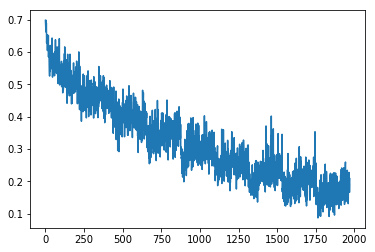

In [ ]:
plt.plot(loss_c)

In [ ]:
from matplotlib import pyplot as plt
params = {'batch_size': 256,
              'shuffle': True,
              'num_workers': 6}

dataFolder = './data'

df_ddi = pd.read_csv('../data/BIOSNAP/sup_test.csv')  # ddi dataframe drug1_smiles, drug2_smiles
labels_sup = df_ddi.label.values
test_set = supData(df_ddi.index.values, labels_sup, df_ddi)
test_generator_sup = data.DataLoader(test_set, **params)

model_nn = model_max

y_pred = []
y_label = []
model_nn.eval()
for i, (v_D, label) in tqdm(enumerate(test_generator_sup)):
    recon, code, score, Z_f, z_D = model_nn(v_D.float())
    m = torch.nn.Sigmoid()
    logits = torch.squeeze(m(score)).detach().cpu().numpy()
    label_ids = label.to('cpu').numpy()
    y_label = y_label + label_ids.flatten().tolist()
    y_pred = y_pred + logits.flatten().tolist()

63it [13:01, 12.41s/it]


0.8941994440870269

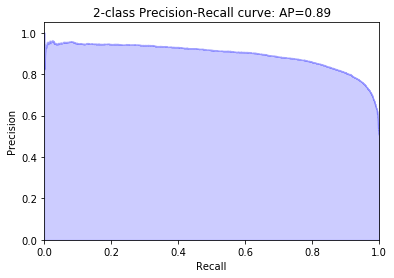

In [ ]:
from sklearn.metrics import average_precision_score
average_precision_score(y_label, y_pred)
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
average_precision = average_precision_score(y_label, y_pred)
precision, recall, _ = precision_recall_curve(y_label, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
average_precision

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report

fpr, tpr, thresholds = roc_curve(y_label, y_pred)
auc_score = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

NameError: name 'y_label' is not defined